In [1]:
from functools import cmp_to_key
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns

sns.set(rc={'figure.figsize': (15, 15)})

In [2]:
### Defining necessary constants

COLORS = ['#EC6899', '#ABCDF2', '#EC6899', '#ABCDF2']
PATCH1 = Patch('black', COLORS[0])
PATCH2 = Patch('black', COLORS[1])

DATA_FOLDER = '/home/faranio/Desktop/EDISS/Courses/1st Year. Period 1/Data Intensive Engineering ' \
              'I/Brain-Neuroactivity/data/'

VIDEOS_FOLDER = os.path.join(DATA_FOLDER, '02_converted')
TABLES_FOLDER = os.path.join(DATA_FOLDER, '07_pose_tables')
BORDERS_FOLDER = os.path.join(DATA_FOLDER, '10_borders_tables')
DATASET_FOLDER = os.path.join(DATA_FOLDER, '11_dataset')

ARENA_LENGTH = 45 # in cm
PROXIMITY = 7     # in cm

In [3]:
def video_name_sort(a, b):
    regex = r'\d+'
    a_nums, b_nums = re.findall(regex, a['Video']), re.findall(regex, b['Video'])
    
    for i, j in zip(a_nums, b_nums):
        if int(i) > int(j):
            return 1
        if int(i) < int(j):
            return -1
    
    return 0

In [4]:
def calculate_units_per_cm(video_file_name):
    borders_keypoints_path = os.path.join(BORDERS_FOLDER, f'{video_file_name}.predictions.h5')
    border_tables = h5py.File(borders_keypoints_path, 'r')
    
    border_x, border_y = border_tables['tracks'][0]
    border_x, border_y = border_x.transpose(), border_y.transpose()
    
    border_x_mean, border_y_mean = np.nanmean(border_x, axis=0), np.nanmean(border_y, axis=0)

    left_upper_corner = (border_x_mean[0], border_y_mean[0])
    right_upper_corner = (border_x_mean[1], border_y_mean[1])

    units_per_cm = np.linalg.norm(np.array(right_upper_corner) - np.array(left_upper_corner)) / ARENA_LENGTH
    return units_per_cm

def get_video_config(video_file_name):
    units_per_cm = calculate_units_per_cm(video_file_name)
    cap = cv2.VideoCapture(os.path.join(VIDEOS_FOLDER, video_file_name))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    bin_length_in_seconds = 60
    interval = int(bin_length_in_seconds * fps)
    duration_in_seconds = frame_count / fps
    
    config = {
        'bin_length': bin_length_in_seconds,
        'duration': duration_in_seconds,
        'fps': fps,
        'frame_count': frame_count,
        'interval': interval,
        'units_per_cm': units_per_cm
    }
    
    return config

def derive_df(video_file_name):
    pose_keypoints_path = os.path.join(TABLES_FOLDER, f'{video_file_name}.predictions.h5')
    pose_tables = h5py.File(pose_keypoints_path, 'r')
    pose_node_names = [str(x)[2:-1] for x in pose_tables['node_names'][:]]
    pose_x, pose_y = pose_tables['tracks'][0]
    pose_x, pose_y = pose_x.transpose(), pose_y.transpose()
    
    columns = []

    for node_name in pose_node_names:
        columns.append(f'{node_name}_x')
        columns.append(f'{node_name}_y')

    df = pd.DataFrame(pose_x, columns=[i + '_x' for i in pose_node_names]).join(
        pd.DataFrame(pose_y, columns=[i + '_y' for i in pose_node_names])
    )

    df = df[columns]
    return df

def add_auxiliary_features(df, config):
    df['Mean_Body_Position_1_x'] = df[['Nose_1_x', 'Upper_Body_1_x', 'Lower_Body_1_x', 'Back_1_x']].mean(axis=1)
    df['Mean_Body_Position_1_y'] = df[['Nose_1_y', 'Upper_Body_1_y', 'Lower_Body_1_y', 'Back_1_y']].mean(axis=1)
    
    df['Mean_Body_Position_2_x'] = df[['Nose_2_x', 'Body_2_x', 'Back_2_x']].mean(axis=1)
    df['Mean_Body_Position_2_y'] = df[['Nose_2_y', 'Body_2_y', 'Back_2_y']].mean(axis=1)

    df['Mean_Body_Position_Distance_12'] = np.linalg.norm(
        df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values - df[
            ['Mean_Body_Position_2_x', 'Mean_Body_Position_2_y']].values, axis=1)

    df['Close_Proximity'] = (df['Mean_Body_Position_Distance_12'] / config['units_per_cm']) <= PROXIMITY
    df['Close_Proximity'] = df['Close_Proximity'].astype(int)

    return df

def read_keypoints(file_name):
    h5_file = h5py.File(file_name, 'r')
    scores = list(h5_file['instance_scores'][0])
    node_names = [str(x)[2:-1] for x in h5_file['node_names'][:]]
    point_scores = h5_file['point_scores'][0].transpose()
    x, y = h5_file['tracks'][0]
    x, y = x.transpose(), y.transpose()
    return scores, node_names, point_scores, x, y

def get_minimum_frame_count():
    minimum_frame_count = 1e10
    
    for video_file_name in os.listdir(VIDEOS_FOLDER):
        corner_keypoints_path = os.path.join(BORDERS_FOLDER, f'{video_file_name}.predictions.h5')
        corner_scores, _, _, _, _ = read_keypoints(corner_keypoints_path)
        
        if minimum_frame_count > len(corner_scores):
            minimum_frame_count = len(corner_scores)
            
    return minimum_frame_count

def preprocess_corner_keypoints(x, y):
    corner_x_mean, corner_y_mean = np.nanmean(x, axis=0), np.nanmean(y, axis=0)
    
    left_upper_corner = (corner_x_mean[0], corner_y_mean[0])
    right_upper_corner = (corner_x_mean[1], corner_y_mean[1])
    right_lower_corner = (corner_x_mean[2], corner_y_mean[2])
    left_lower_corner = (corner_x_mean[3], corner_y_mean[3])
    
    return left_upper_corner, right_upper_corner, right_lower_corner, left_lower_corner

def preprocess_pose_keypoints(node_names, point_scores, x, y, corners, units_per_cm):
    columns = []
    
    for node_name in node_names:
        columns.append(f'{node_name}_x')
        columns.append(f'{node_name}_y')
    
    df = pd.DataFrame(x, columns=[i + '_x' for i in node_names]).join(
        pd.DataFrame(y, columns=[i + '_y' for i in node_names])
    )
    
    df = df[columns]

    # Calculating Mean Body Positions of mice

    df['Mean_Body_Position_1_x'] = df[['Nose_1_x', 'Upper_Body_1_x', 'Lower_Body_1_x', 'Back_1_x']].mean(axis=1)
    df['Mean_Body_Position_1_y'] = df[['Nose_1_y', 'Upper_Body_1_y', 'Lower_Body_1_y', 'Back_1_y']].mean(axis=1)

    df['Mean_Body_Position_2_x'] = df[['Nose_2_x', 'Body_2_x', 'Back_2_x']].mean(axis=1)
    df['Mean_Body_Position_2_y'] = df[['Nose_2_y', 'Body_2_y', 'Back_2_y']].mean(axis=1)

    df['Mean_Body_Position_Distance_12'] = np.linalg.norm(df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].values - df[['Mean_Body_Position_2_x', 'Mean_Body_Position_2_y']].values, axis=1)

    df['Close_Proximity'] = (df['Mean_Body_Position_Distance_12'] / units_per_cm) <= PROXIMITY
    df['Close_Proximity'] = df['Close_Proximity'].astype(int)
    
    return df

In [5]:
def total_distance(pos1, pos2, units_per_cm):
    distances = np.linalg.norm(pos2.values - pos1.values, axis=1)
    distances = distances[~np.isnan(distances)]
    distance_in_cm = sum(distances) / units_per_cm
    return distance_in_cm

def total_time_of_interaction(col, duration, frame_count):
    total_time = duration * col.sum() / frame_count
    return total_time

def frequency_of_interaction(interaction_time, length):
    frequency = interaction_time / length
    return frequency

def latency_to_first_interaction(col, duration, frame_count):
    frames = 0

    for idx, val in col.items():
        if val == 0:
            frames += 1
        else:
            break

    latency = frames / frame_count * duration
    
    return latency

def time_stamped_interaction(col, duration, frame_count):
    time_series = []
    
    for k, v in col.items():
        if v != 0:
            val = v * k / frame_count * duration
            val = round(val, 2)
            time_series.append(val)
        
    return time_series

In [6]:
def derive_features(df, config):
    time_of_interaction = total_time_of_interaction(
        df['Close_Proximity'],
        config['duration'],
        config['frame_count']
    )
    first_interaction_latency = latency_to_first_interaction(
        df['Close_Proximity'],
        config['duration'],
        config['frame_count']
    )
    time_stamped_active_interaction = time_stamped_interaction(
        df['Close_Proximity'],
        config['duration'],
        config['frame_count']
    )
    interaction_frequency = frequency_of_interaction(
        time_of_interaction,
        config['duration']
    )
    distance_traveled = total_distance(
        df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']],
        df[['Mean_Body_Position_1_x', 'Mean_Body_Position_1_y']].shift(),
        config['units_per_cm']
    )
    results = {
        'distance_moved': distance_traveled,
        'first_interaction_latency': first_interaction_latency,
        'interaction_frequency': interaction_frequency,
        'time_of_active_interaction': time_of_interaction,
        'time_stamped_active_interaction': time_stamped_active_interaction
    }
    
    return results

In [7]:
def read_dataset(interpolation=False):
    file_path = os.path.join(DATASET_FOLDER, 'new_dataset.pickle')
    
    if os.path.exists(file_path):
        with open(file_path, 'rb') as file:
            dataset = pickle.load(file)
    else:
        dataset = []
        min_frame_count = get_minimum_frame_count()
        
        for video_file_name in os.listdir(VIDEOS_FOLDER):
            config = get_video_config(video_file_name)
            df = derive_df(video_file_name)
            df = add_auxiliary_features(df, config)
            
            if interpolation:
                df = df.interpolate()
                
            df = df.iloc[:min_frame_count, :]
            
            features = derive_features(df, config)
            
            record = {
                'Video': video_file_name,
                'Config': config,
                'Data': df,
                'Features': features
            }
            
            dataset += [record]
        
        with open(file_path, 'wb') as file:
            pickle.dump(dataset, file, protocol=pickle.HIGHEST_PROTOCOL)
            
    dataset = sorted(dataset, key=cmp_to_key(video_name_sort))
            
    first_experiment_dataset = []
    second_experiment_dataset = []
    
    for i in range(len(dataset)):
        if '_v3_' in dataset[i]['Video']:
            second_experiment_dataset += [dataset[i]]
        else:
            first_experiment_dataset += [dataset[i]]
            
    return first_experiment_dataset, second_experiment_dataset    

In [8]:
first_dataset, second_dataset = read_dataset()

In [9]:
def get_features_for_clustering(dataset):
    X = []
    columns = list(dataset[0]['Features'].keys())[:4]
    columns.extend(['has_treatment', 'is_week_6'])

    for i in range(len(dataset)):
        values = list(dataset[i]['Features'].values())
        del values[4]  # Deleting time stamped active interaction

        if '_control_' in dataset[i]['Video']:
            values.append(0)
        else:
            values.append(1)

        if '_w6_' in dataset[i]['Video']:
            values.append(1)
        else:
            values.append(0)

        X.append(values)

    X = np.array(X)
    X = pd.DataFrame(X, columns=columns)
    X = X.drop(columns='interaction_frequency')
    X[['has_treatment', 'is_week_6']] = X[['has_treatment', 'is_week_6']].astype(bool)
    
    return X

In [35]:
X = get_features_for_clustering(second_dataset)
n_clusters = 2
X

,distance_moved,first_interaction_latency,time_of_active_interaction,has_treatment,is_week_6
0,2646.594124,18.68,97.84,False,False
1,1990.489578,2.88,90.60,False,True
2,2483.927238,51.40,97.12,True,False
3,1588.905850,1.72,80.28,True,True
4,2440.049849,20.08,106.36,False,False
5,1717.546104,5.68,118.68,False,True
6,2672.247404,1.60,143.36,True,False
7,2293.304876,4.00,78.24,True,True
8,299.801346,302.64,0.00,True,False
9,714.649968,0.92,16.88,True,True


<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


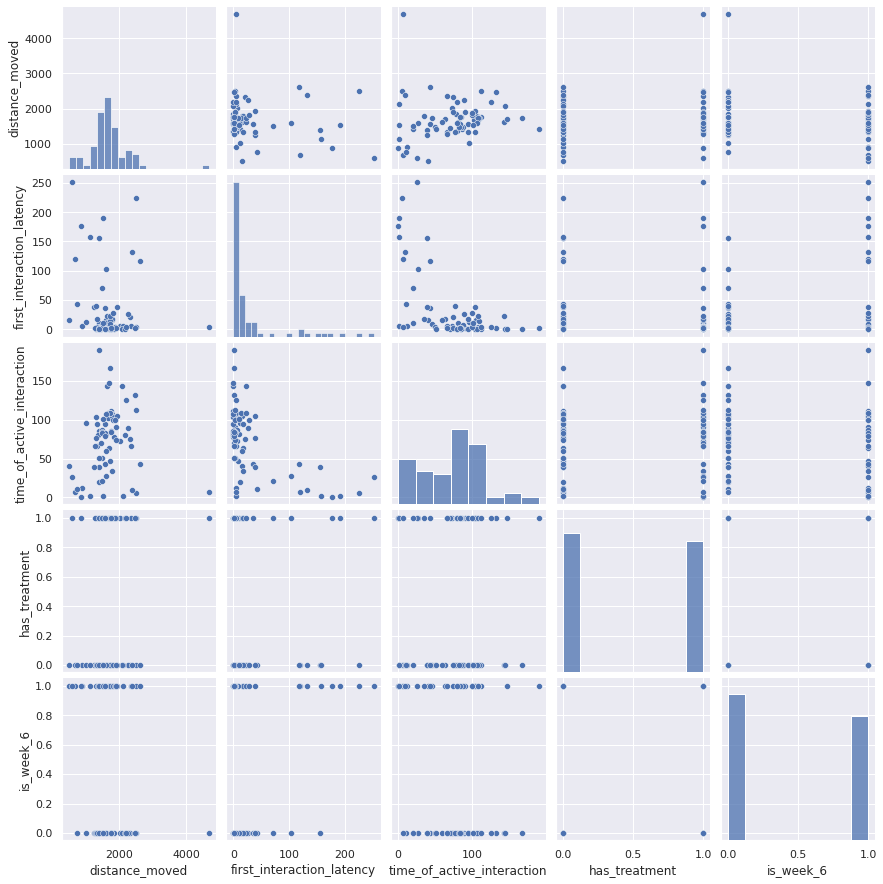

In [13]:
sns.pairplot(X);

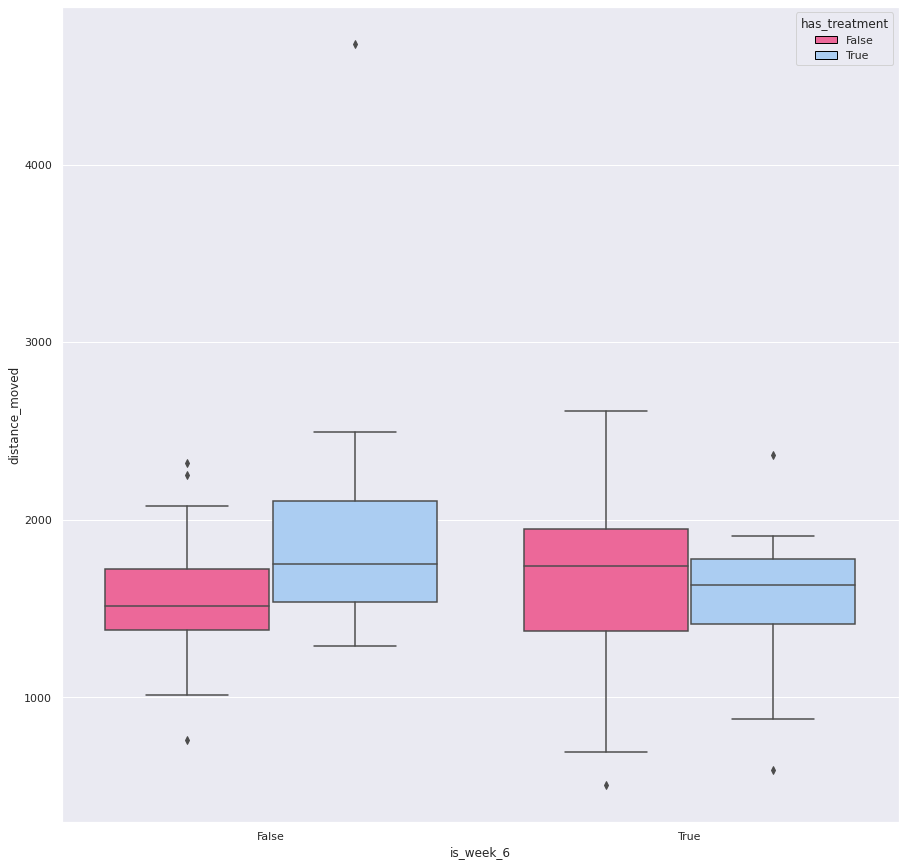

In [14]:
boxplot = sns.boxplot(y='distance_moved', x='is_week_6', hue='has_treatment', data=X);

for i in range(4):
    box = boxplot.artists[i]
    box.set_facecolor(COLORS[i])
    
boxplot.legend([PATCH1, PATCH2], ['False', 'True'], title='has_treatment')
plt.show()

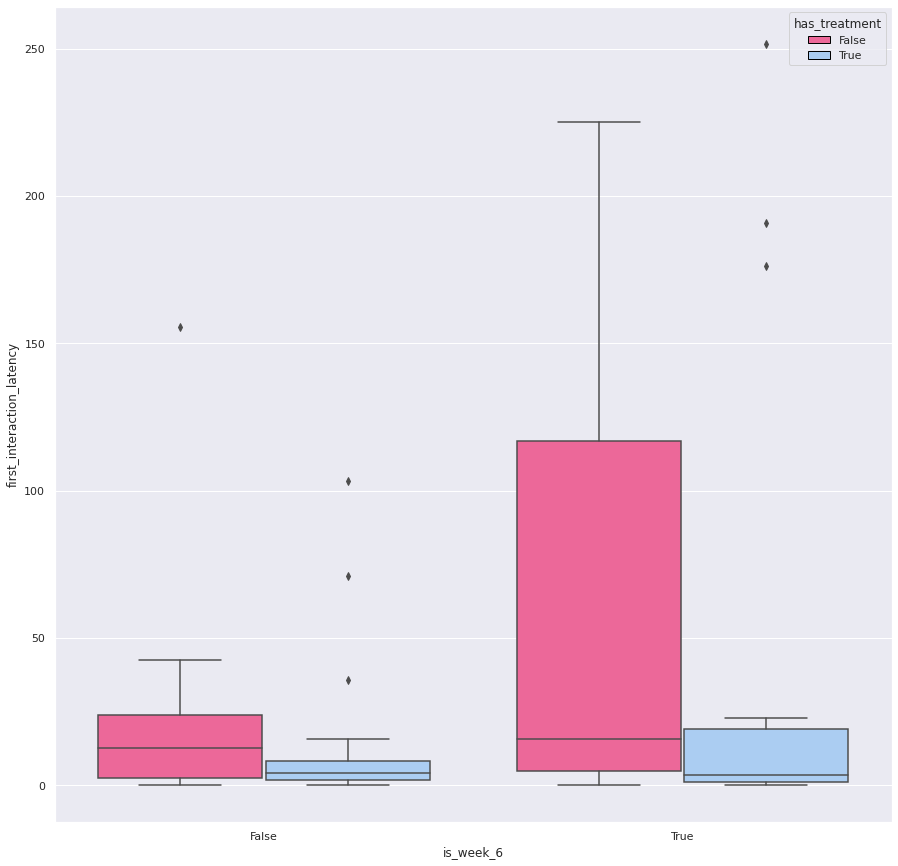

In [15]:
boxplot = sns.boxplot(y='first_interaction_latency', x='is_week_6', hue='has_treatment', data=X);

for i in range(4):
    box = boxplot.artists[i]
    box.set_facecolor(COLORS[i])
    
boxplot.legend([PATCH1, PATCH2], ['False', 'True'], title='has_treatment')
plt.show()

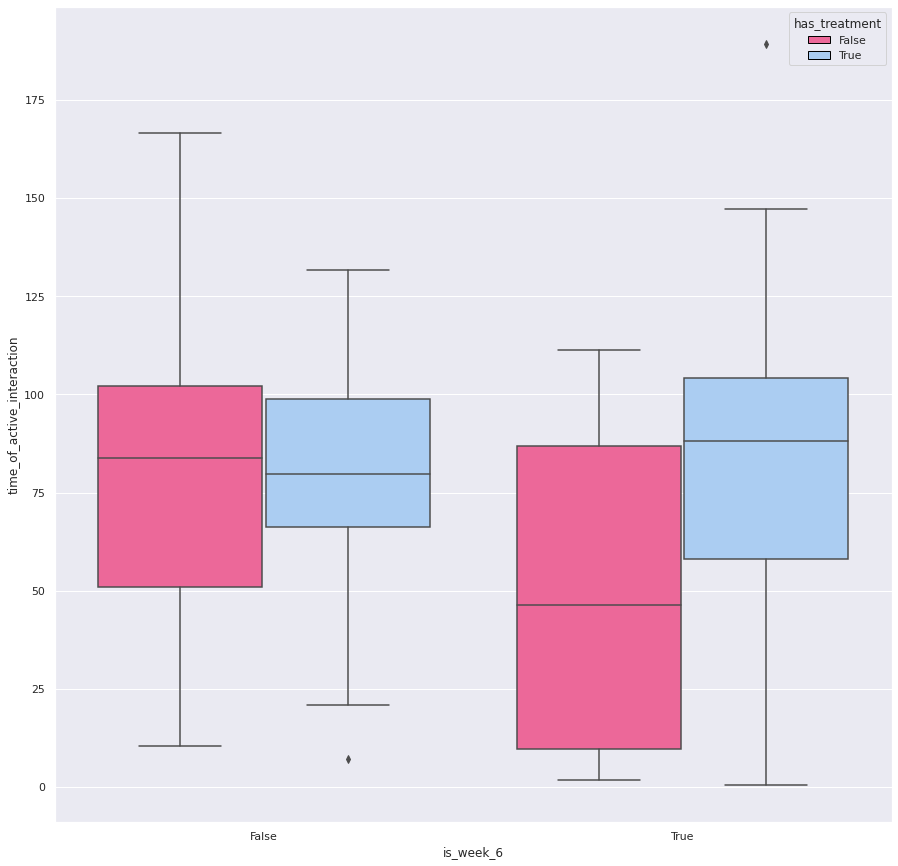

In [16]:
boxplot = sns.boxplot(y='time_of_active_interaction', x='is_week_6', hue='has_treatment', data=X);

for i in range(4):
    box = boxplot.artists[i]
    box.set_facecolor(COLORS[i])
    
boxplot.legend([PATCH1, PATCH2], ['False', 'True'], title='has_treatment')
plt.show()

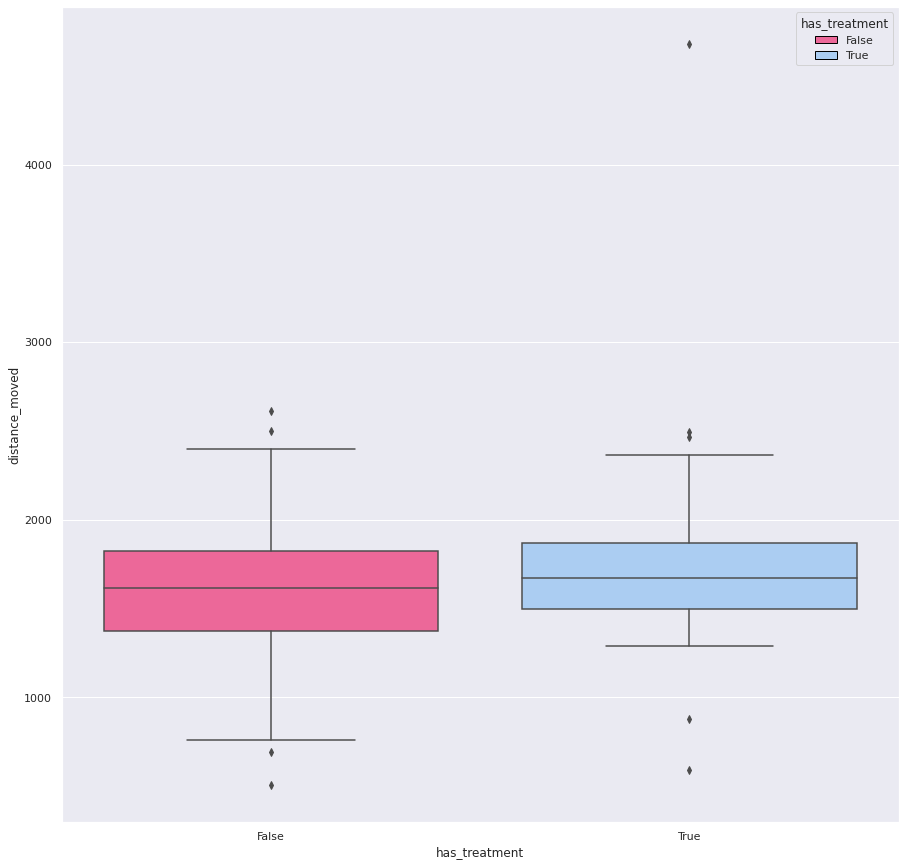

In [17]:
boxplot = sns.boxplot(y='distance_moved', x='has_treatment', data=X);

for i in range(2):
    box = boxplot.artists[i]
    box.set_facecolor(COLORS[i])
    
boxplot.legend([PATCH1, PATCH2], ['False', 'True'], title='has_treatment')
plt.show()

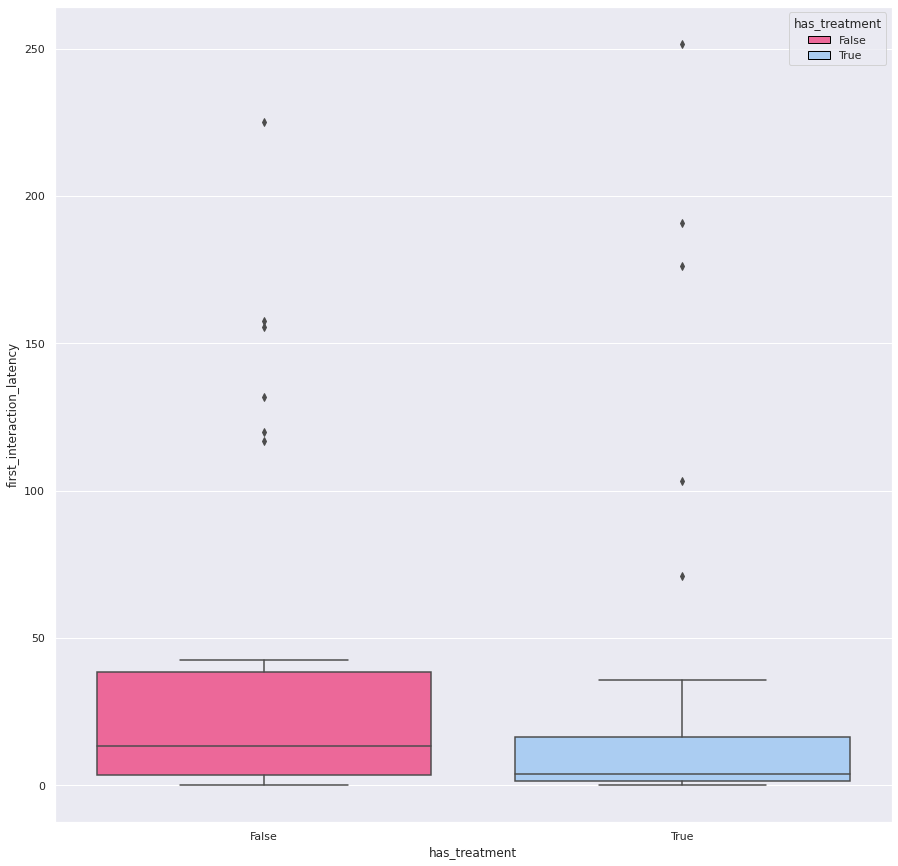

In [18]:
boxplot = sns.boxplot(y='first_interaction_latency', x='has_treatment', data=X);

for i in range(2):
    box = boxplot.artists[i]
    box.set_facecolor(COLORS[i])
    
boxplot.legend([PATCH1, PATCH2], ['False', 'True'], title='has_treatment')
plt.show()

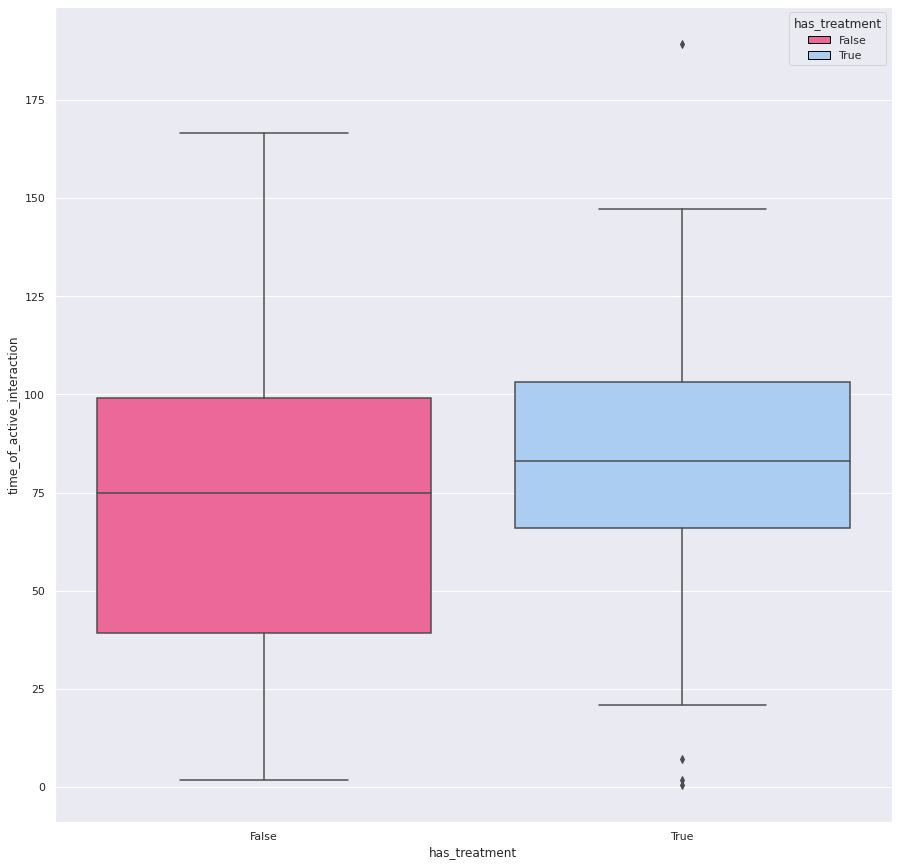

In [19]:
boxplot = sns.boxplot(y='time_of_active_interaction', x='has_treatment', data=X);

for i in range(2):
    box = boxplot.artists[i]
    box.set_facecolor(COLORS[i])
    
boxplot.legend([PATCH1, PATCH2], ['False', 'True'], title='has_treatment')
plt.show()

In [36]:
train_X = X[[
    'distance_moved', 
    'first_interaction_latency', 
    'time_of_active_interaction'
]]

In [37]:
train_X

,distance_moved,first_interaction_latency,time_of_active_interaction
0,2646.594124,18.68,97.84
1,1990.489578,2.88,90.60
2,2483.927238,51.40,97.12
3,1588.905850,1.72,80.28
4,2440.049849,20.08,106.36
5,1717.546104,5.68,118.68
6,2672.247404,1.60,143.36
7,2293.304876,4.00,78.24
8,299.801346,302.64,0.00
9,714.649968,0.92,16.88


In [38]:
from tslearn.clustering import silhouette_score, TimeSeriesKMeans

clusterer = TimeSeriesKMeans(
    metric='euclidean',
    n_clusters=n_clusters,
    n_jobs=-1,
    random_state=0
)
y_pred = clusterer.fit_predict(train_X)

In [39]:
train_X[y_pred == 0].describe()

,distance_moved,first_interaction_latency,time_of_active_interaction
count,14.000000,14.000000,14.000000
mean,2284.060201,16.951429,110.548571
std,302.786878,22.300627,36.425291
min,1810.606373,0.000000,52.240000
25%,2077.575863,3.130000,92.230000
50%,2207.920616,6.380000,104.300000
75%,2472.957891,19.730000,129.770000
max,2843.388292,76.480000,187.920000


In [40]:
train_X[y_pred == 1].describe()

,distance_moved,first_interaction_latency,time_of_active_interaction
count,28.000000,28.000000,28.000000
mean,1196.266855,29.205714,73.274286
std,344.601664,62.164734,39.264400
min,299.801346,0.000000,0.000000
25%,996.308101,2.020000,48.230000
50%,1194.915422,5.260000,70.660000
75%,1474.750503,30.390000,92.640000
max,1717.546104,302.640000,166.040000


/home/faranio/Desktop/EDISS/Courses/1st Year. Period 1/Data Intensive Engineering I/Brain-Neuroactivity/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


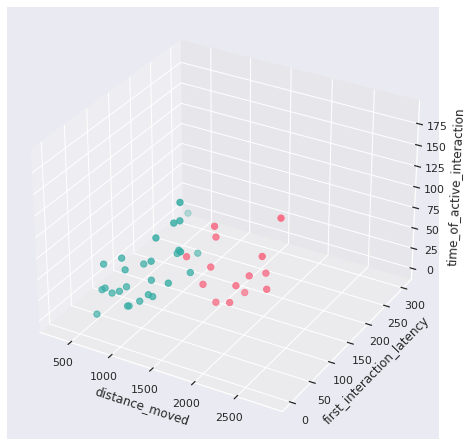

In [48]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
fig.add_axes(ax)

color_palette = sns.color_palette("husl", n_clusters).as_hex()

cmap = ListedColormap(color_palette)

sc = ax.scatter(
    train_X['distance_moved'], 
    train_X['first_interaction_latency'], 
    train_X['time_of_active_interaction'], 
    s=40, 
    c=y_pred, 
    marker='o',
    cmap=cmap
)

ax.set_xlabel('distance_moved')
ax.set_ylabel('first_interaction_latency')
ax.set_zlabel('time_of_active_interaction')

plt.show()

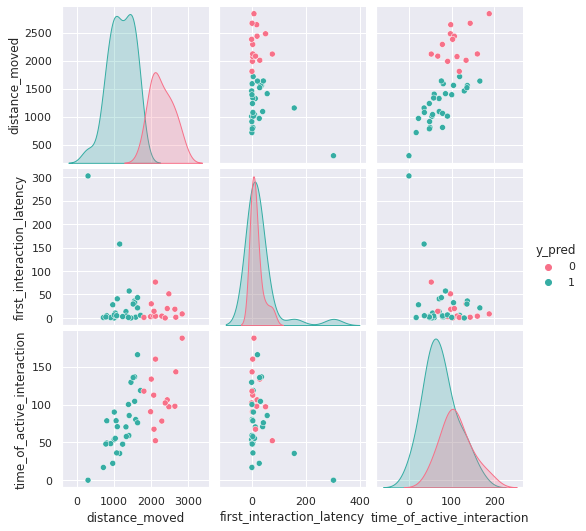

In [141]:
temp_X = train_X.copy()
temp_X['y_pred'] = y_pred
sns.pairplot(temp_X, hue='y_pred', palette=color_palette);